--- 1. Cấu hình ---
Sử dụng thiết bị: mps

--- 2. Load Model Pre-trained (ResNet50) ---
Load ResNet50 thành công.

--- 3. Chuẩn bị Ảnh (Theo chuẩn ImageNet) ---
Chuẩn bị ảnh thành công.

--- 4. Thực hiện Grad-CAM ---
Đăng ký hooks vào layer: Bottleneck
Model dự đoán index lớp ImageNet: 655
Tính toán heatmap thành công.

--- 5. Trực quan hóa ---


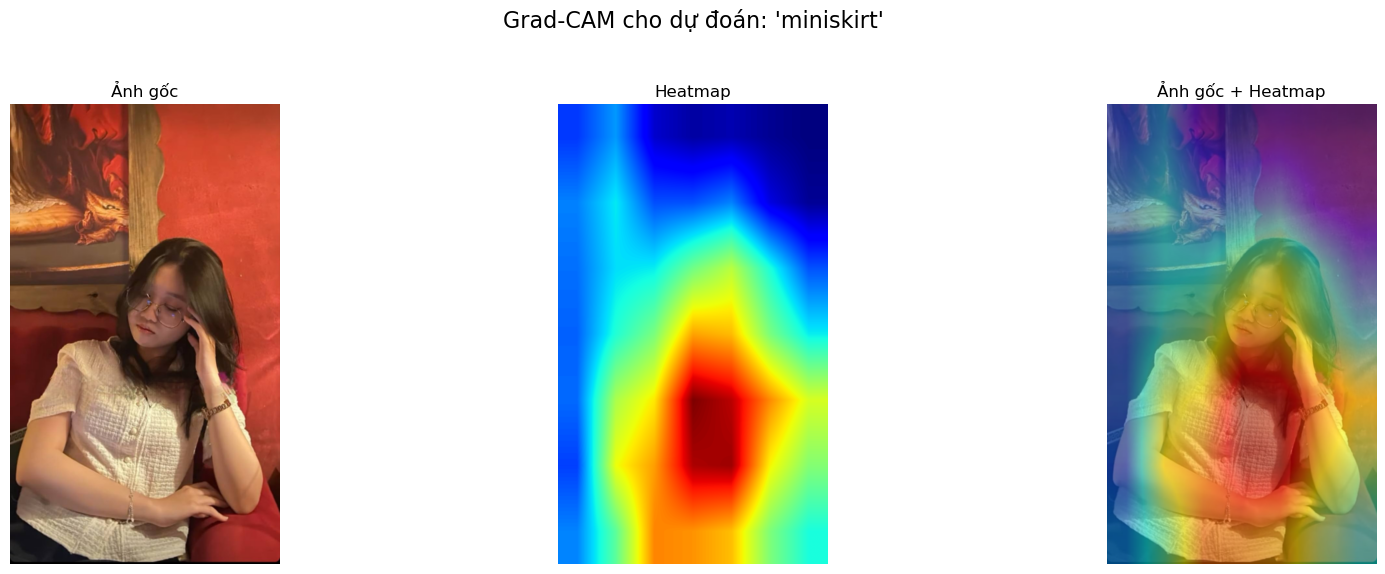

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json
import requests

print("--- 1. Cấu hình ---")

IMAGE_PATH = '/Users/namtran/Downloads/c16456fa-24bf-43c1-86a3-035021000c15.jpeg' # Đường dẫn ảnh đã cập nhật
TARGET_LAYER_NAME = 'layer4'
IMAGE_SIZE = 224
GRAD_CAM_ALPHA = 0.5

if not os.path.exists(IMAGE_PATH):
    print(f"Lỗi: Không tìm thấy ảnh tại '{IMAGE_PATH}'")
    exit()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Sử dụng thiết bị: {DEVICE}")

print("\n--- 2. Load Model Pre-trained (ResNet50) ---")
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.eval()
model = model.to(DEVICE)
print("Load ResNet50 thành công.")

print("\n--- 3. Chuẩn bị Ảnh (Theo chuẩn ImageNet) ---")
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

try:
    img_pil = Image.open(IMAGE_PATH).convert('RGB')
    input_tensor = preprocess(img_pil)
    input_batch = input_tensor.unsqueeze(0).to(DEVICE)
    print("Chuẩn bị ảnh thành công.")
except Exception as e:
    print(f"Lỗi khi xử lý ảnh: {e}")
    exit()

print("\n--- 4. Thực hiện Grad-CAM ---")
feature_maps = None
gradients = None

def forward_hook(module, input, output):
    global feature_maps; feature_maps = output.detach()

def backward_hook(module, grad_input, grad_output):
    global gradients; gradients = grad_output[0].detach()

target_module = None
try:
    if TARGET_LAYER_NAME == 'layer4': target_module = model.layer4[-1]
    else:
        for name, module in model.named_modules():
            if name == TARGET_LAYER_NAME: target_module = module; break
    if target_module is None: raise ValueError(f"Không tìm thấy layer '{TARGET_LAYER_NAME}'.")

    forward_handle = target_module.register_forward_hook(forward_hook)
    if hasattr(target_module, 'register_full_backward_hook'):
        backward_handle = target_module.register_full_backward_hook(backward_hook)
    else:
        backward_handle = target_module.register_backward_hook(backward_hook)
    print(f"Đăng ký hooks vào layer: {target_module.__class__.__name__}")

except Exception as e:
    print(f"Lỗi đăng ký hook: {e}")
    exit()

model.zero_grad()
output_logits = model(input_batch)
probabilities = F.softmax(output_logits, dim=1)
predicted_class_index = torch.argmax(probabilities, dim=1).item()
predicted_class_score = output_logits[0, predicted_class_index]

print(f"Model dự đoán index lớp ImageNet: {predicted_class_index}")
predicted_class_score.backward()

if gradients is None or feature_maps is None:
    print("Lỗi: Không lấy được gradients/feature maps.")
    forward_handle.remove(); backward_handle.remove()
    exit()

pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
for i in range(feature_maps.shape[1]): feature_maps[:, i, :, :] *= pooled_gradients[i]
heatmap = torch.mean(feature_maps, dim=1).squeeze()
heatmap = F.relu(heatmap)
max_val = torch.max(heatmap)
heatmap = heatmap / (max_val + 1e-10)
heatmap_np = heatmap.cpu().numpy()
print("Tính toán heatmap thành công.")

predicted_class_name = f"ImageNet Class {predicted_class_index}"
try:
    LABELS_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
    response = requests.get(LABELS_URL)
    response.raise_for_status()
    imagenet_labels = response.json()
    if 0 <= predicted_class_index < len(imagenet_labels):
        predicted_class_name = imagenet_labels[predicted_class_index]
    else:
        print(f"Cảnh báo: Index dự đoán {predicted_class_index} nằm ngoài phạm vi nhãn ImageNet.")
except requests.exceptions.RequestException as e:
    print(f"Cảnh báo: Không thể tải nhãn ImageNet: {e}.")
except Exception as e:
    print(f"Lỗi khi xử lý nhãn ImageNet: {e}")

print("\n--- 5. Trực quan hóa ---")
img_display_pil = Image.open(IMAGE_PATH).convert('RGB')
img_display_np = np.array(img_display_pil)
heatmap_resized = cv2.resize(heatmap_np, (img_display_np.shape[1], img_display_np.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
heatmap_colored_rgb = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
superimposed_img_np = np.uint8(heatmap_colored_rgb * GRAD_CAM_ALPHA + img_display_np * (1 - GRAD_CAM_ALPHA))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"Grad-CAM cho dự đoán: '{predicted_class_name}'", fontsize=16)
axs[0].imshow(img_display_np); axs[0].set_title('Ảnh gốc'); axs[0].axis('off')
axs[1].imshow(heatmap_resized, cmap='jet'); axs[1].set_title('Heatmap'); axs[1].axis('off')
axs[2].imshow(superimposed_img_np); axs[2].set_title('Ảnh gốc + Heatmap'); axs[2].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

forward_handle.remove()
backward_handle.remove()